**Atenção: Devido a natureza dos dados, para correto funcionamento, este notebook precisa ser executado em ambiente com memória RAM maior ou igual a 25 Gb.**

#**Ciência e Visualização de Dados**
##**Projeto Final - Entrega 03**
###Alunos: 
###Gleyson Roberto do Nascimento. RA: 043801. Elétrica.
###Negli René Gallardo Alvarado. RA: 234066. Saúde.
###Rafael Vinícius da Silveira. RA: 137382. Física.
###Sérgio Sevileanu. RA: 941095. Elétrica.



##Neste notebook do Google Colaboratory será realzada a aprendizagem de máquina para os dados do Estado do Pará durante os anos de 2008 a 2018 segundo o banco de dados [SIHSUS](https://bigdata-metadados.icict.fiocruz.br/dataset/sistema-de-informacoes-hospitalares-do-sus-sihsus/resource/ae85ac54-6734-43b8-a820-6129a854e1ff).

##Desta forma, algumas definições iniciais e um disclaimer se fazem necessários para este projeto:

##Será definido como **diagnóstico equivocado (categoria 0 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte do mesmo grupo, de forma que é plausível o equívoco dada a semelhança de sintomas entre os CID10;
##Será definido como **falha de diagnóstico (categoria 1 da variável v258)** aquele em que houve mais de um diagnóstico de CID10, contudo, eles fazem parte de grupos distintos, de forma que embora possam existir sintomas semelhantes entre os CID10, caberia ao profissional uma análise mais aprofundada antes do diagnóstico.
##O **diagnóstico correto** (aquele em que houve apenas um diagnóstico de CID10, sem alterações durante o período até a alta) foi suprimido da análise devido ao fato de que evisiesava  resultados dado o altíssimo percentual de ocorrência; 
##**Disclaimer**: Considerando a natureza do banco de dados do SIHSUS, isto é, um Big Data em que inúmeros funcionários do Sistema Único de Saúde possuem acesso e inserem os dados de forma manual em realdades e condições bastante distintas, existe a séria possibildade de erro sistemático, desta forma, a acurácia deste trabalho deve ser considerada com ressalvas.

#Instalando o RAPIDS no Google Colab

##Verificando se há GPU disponível

In [1]:
!nvidia-smi

Wed Jun 23 23:44:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 272 (delta 56), reused 38 (delta 19), pack-reused 171
Receiving objects: 100% (272/272), 79.66 KiB | 4.19 MiB/s, done.
Resolving deltas: 100% (118/118), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla V100-SXM2-16GB!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:8 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease [20.8 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/

In [1]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:28
🔁 Restarting kernel...


In [1]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [2]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable

Installing RAPIDS Stable 21.06
Starting the RAPIDS+BlazingSQL install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - cudatoolkit=11.0
    - gcsfs
    - llvmlite
    - openssl
    - python=3.7
    - rapids-blazing=21.06


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  conda-forge
    aiohttp-3.7.4.post0        |   py37h5e8e339_0         625 KB  conda-forge
    anyio-3.2.0                |   py37h89c1867_0         138 KB  conda-forge
    appdirs-1.4.4              |     pyh9f0ad1d_0      

#Instalando as Bibliotecas Necessárias

In [3]:
%matplotlib inline
%load_ext google.colab.data_table
import matplotlib.pyplot as plt
import numpy as np
import gc
import pandas as pd
import pickle
import dask
import dask_cudf
import cudf
from datetime import datetime
from dask import dataframe as dd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials
pd.set_option('display.max_columns', None)
pd.options.display.precision = 2
pd.options.display.max_rows = 50
import seaborn as sns
import missingno as msno
import matplotlib as mpl
from matplotlib import rcParams
from numba import jit, njit
mpl.rc('figure', max_open_warning = 0)
from sklearn import preprocessing

#Criando um Client para o Dask

In [4]:
from dask.distributed import Client,wait
client = Client()
#client = Client(n_workers=2, threads_per_worker=4)
client.cluster

/usr/local/lib/python3.7/site-packages/distributed/client.py:1148: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.19.5 | 1.19.5    | 1.21.0  |
| tornado | 5.1.1  | 5.1.1     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


#Fazendo autenticação no Google, importando os arquivos através do Google Drive e criando Dask dataframes com limpeza de ram (garbage collect).

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
ids = ['1Oyd1VdQo3fHJD5LGXNgi5kZBS812MiKN','183SF0fxXbTVXYfko-BOyuwAB2BmZQAmK']
estados = ['BR','BRPRO']
arquivo = ['brasil.pkl','brasilprocessed.pkl']

In [7]:
dflist=[]
for i in range (len(ids)):
  fileDownloaded = drive.CreateFile({'id':ids[i]})
  fileDownloaded.GetContentFile(arquivo[i])
  globals()[estados[i]] = dd.from_pandas(pd.read_pickle(arquivo[i]),npartitions=245)
  n=gc.collect()
  globals()[estados[i]] = (globals()[estados[i]]).reset_index(drop=True)
  n=gc.collect()
  dflist.append(eval(estados[i]))
  n=gc.collect()

In [8]:
dflist[0].head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v82,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v104,v105,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v225,v226,v227,v228,v229,v230,v231,v232,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v253,v254,v255,v256,v257,v258,v259
0,120000,2008,12,2,5.29e+11,1208100502730,AIH normal,1208100502730,1,Normal,69900100,120040,12,19791012,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,5,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081206,20081211,O324,O630,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,29,5,5,0,Sem óbito,10,2,2,2,2,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103541,0,Seqüencial zerado,0,0,0,NaN,1,21706700172,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3046,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,29,15-49a,25-34a,25-29a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Assistência prestada à mãe por motivo de apres...,Assistência prestada à mãe por polo cefálico a...,NaN,NaN,NaN,NaN,2008,sab,2008,qui,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,O32,O63,NaN,NaN,NaN,Falha de Diagnóstico,Não houve óbito
1,120000,2008,12,2,5.29e+11,1208100502774,AIH normal,1208100502774,1,Normal,69900970,120040,12,19760827,3,Feminino,0,0,0,0,Não utilizou UTI,0,0,3,411010026,411010026,700.79,447.15,1147.94,0.0,496.94,20081209,20081212,O410,O48,17,Alta da mãe/puérpera e do recém-nascido,61,NaN,NaN,2,Estadual plena,1,Sim,120040,12,4,Anos,32,3,3,0,Sem óbito,10,2,2,0,Não,0,Sem filhos/Não inform,0,NaN,0,0,1,Sim,1208103511,0,Seqüencial zerado,0,0,0,NaN,0,0,2002078,5.29e+11,NaN,NaN,2,Média complexidade,6,Média e Alta Complexidade (MAC),0,Sem regra contratual,3,Parda,NaN,3050,HE12000001N200812.DTS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153.0,9222.58,120040,120040,Rio Branco,RIO BRANCO,S,S,S,12,1290,1201,12900,-9.97,-67.81,153,9222.58,120040,AC,12,ACRE,AC,ACRE,Região Norte,Região Norte,Acre,AC,Acre,AC,Rio Branco,Rio Branco,NaN,NaN,Baixo Acre e Purus,Baixo Acre e Purus,Rio Branco,Rio Branco,Vale do Acre,Vale do Acre,Rio Branco,Acre,Acre,Região não definida - AC,Região não definida - AC,NaN,Brasil,Não Informado,Obstétricos,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,PARTO CESARIANO EM GESTACAO DE ALTO RISCO,32,15-49a,25-34a,30-34a,Capítulo XV - Gravidez; parto e puerpério,Assistência prestada à mãe por motivos ligados...,Outros transtornos das membranas e do líquido ...,Oligohidrâmnio,NaN,NaN,NaN,NaN,2008,ter,2008,sex,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.

#Fazendo a Aprendizem de Máquina com Computação Paralela.

##Instalando o Dask Machine Learning.

In [17]:
!pip install dask-ml

##Instalando as Bibliotecas Necessárias do Sklearn 

In [18]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib
from dask_ml.model_selection import train_test_split
import warnings

##Ajustando os dados para tratamento por Machine Learning

In [19]:
t1 = (dflist[1]).drop(['v49','v82','v104','v105','v225','v226','v227','v228','v229','v230','v231','v232','v253','v254','v255','v256','v257'], axis=1)
n=gc.collect()

In [20]:
t1 = t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259','v258']]
n=gc.collect()
t1 = t1.loc[t1['v0'].between(150000, 151000,inclusive=True)]
t1.head()

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v19,v20,v21,v22,v23,v27,v28,v29,v30,v31,v32,v33,v43,v44,v45,v46,v47,v48,v50,v51,v52,v54,v55,v56,v57,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v72,v73,v76,v77,v78,v79,v80,v83,v85,v87,v88,v89,v90,v91,v92,v93,v94,v96,v97,v98,v100,v101,v106,v107,v108,v109,v112,v113,v114,v115,v116,v117,v118,v121,v122,v123,v124,v125,v126,v127,v128,v137,v138,v139,v141,v143,v145,v147,v149,v151,v153,v155,v156,v157,v158,v159,v160,v161,v162,v163,v164,v165,v166,v167,v168,v169,v170,v171,v172,v173,v174,v175,v176,v177,v178,v179,v180,v181,v182,v183,v184,v185,v186,v187,v188,v189,v192,v193,v194,v195,v196,v197,v198,v199,v200,v201,v202,v203,v204,v205,v206,v207,v208,v209,v210,v211,v212,v213,v215,v216,v218,v219,v220,v221,v222,v223,v224,v234,v235,v237,v238,v239,v241,v242,v243,v244,v245,v246,v247,v248,v249,v250,v261,v251,v252,v260,v262,v259,v258


##Fazendo a Separação de Dados de Treino (70%) e Dados de Teste (30%).

In [21]:
xtreino, xteste, ytreino, yteste = train_test_split((t1.iloc[:,0:191]),(t1.iloc[:,191:]), test_size = 0.3,random_state=66,shuffle=True)
n=gc.collect()

##Modelo 0: Regressão Logística.

In [22]:
model = LogisticRegression(C=30000, dual=False, max_iter=3000000)

In [23]:
from joblib import parallel_backend

In [24]:
with parallel_backend('dask'):
  model.fit(xtreino,ytreino)

In [25]:
n=gc.collect()

R² de treino: 0.9931922083084874 R² de teste: 0.9911935110081113
Intercept: [-1.25702523e-08] 
RMSE de Treino: 0.006807791691512622 RMSE de Teste: 0.00880648899188876


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.75      0.42      0.54       191
           1       0.99      1.00      1.00     19933

    accuracy                           0.99     20124
   macro avg       0.87      0.71      0.77     20124
weighted avg       0.99      0.99      0.99     20124





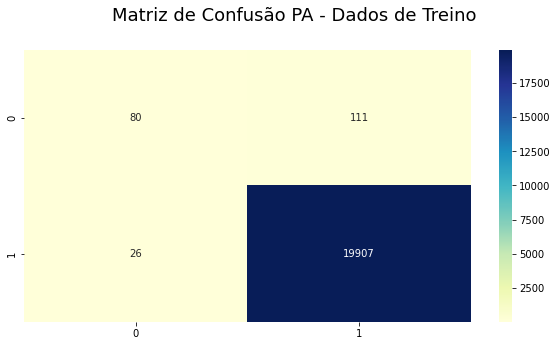



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.60      0.37      0.46        87
           1       0.99      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.80      0.68      0.73      8630
weighted avg       0.99      0.99      0.99      8630





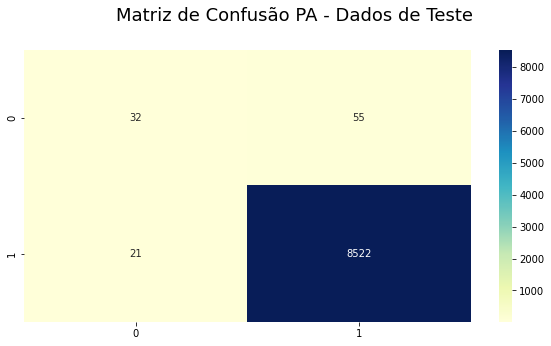

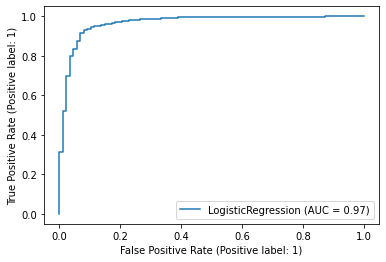

In [26]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model.score(xteste,yteste))
  print('\033[1m'+'Intercept:'+'\033[0m',model.intercept_,'\033[1m')
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model,xteste,yteste)
  plt.show()
  print('\n')

In [27]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model.coef_).T
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [28]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
129,0.01,v180
49,0.01,v67
48,0.01,v66
90,0.01,v125
31,0.01,v46
...,...,...
156,-0.01,v209
50,-0.01,v68
70,-0.03,v96
35,-0.13,v51


In [29]:
n=gc.collect()

##Modelo 1: Árvore de Decisão.

In [30]:
model1 = DecisionTreeClassifier(max_depth=2, random_state=18)

In [31]:
with parallel_backend('dask'):
  model1.fit(xtreino,ytreino)

In [32]:
n=gc.collect()

R² de treino: 0.9936891274100577 R² de teste: 0.9937427578215527
RMSE de Treino: 0.0063108725899423575 RMSE de Teste: 0.006257242178447277


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.79      0.46      0.58       191
           1       0.99      1.00      1.00     19933

    accuracy                           0.99     20124
   macro avg       0.89      0.73      0.79     20124
weighted avg       0.99      0.99      0.99     20124





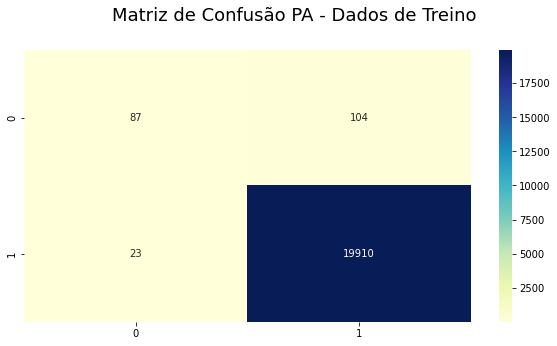



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.84      0.47      0.60        87
           1       0.99      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.92      0.74      0.80      8630
weighted avg       0.99      0.99      0.99      8630





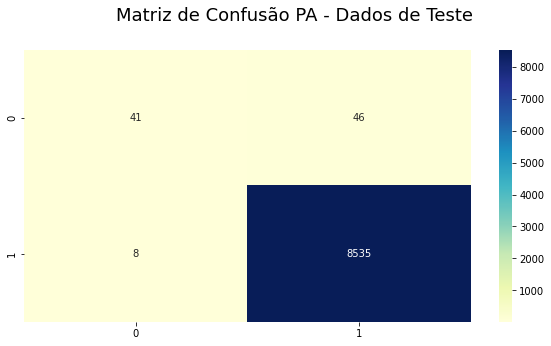

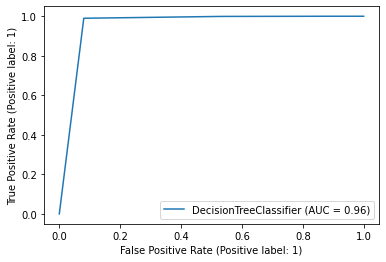

In [33]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model1.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model1.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model1.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model1.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model1.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model1.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model1.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model1.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model1,xteste,yteste)
  plt.show()
  print('\n')

In [34]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model1.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [35]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
51,0.62,v69
164,0.25,v219
149,0.13,v202
0,0.00,v0
131,0.00,v182
...,...,...
66,0.00,v91
67,0.00,v92
68,0.00,v93
69,0.00,v94


In [36]:
n=gc.collect()

##Modelo 2: Ada Boost.

In [37]:
model2 = AdaBoostClassifier(n_estimators=50)

In [ ]:
with parallel_backend('dask'):
  model2.fit(xtreino,ytreino)

In [39]:
n=gc.collect()

R² de treino: 0.9937885112303717 R² de teste: 0.9933951332560834
RMSE de Treino: 0.006211488769628305 RMSE de Teste: 0.00660486674391657


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.71      0.59      0.64       191
           1       1.00      1.00      1.00     19933

    accuracy                           0.99     20124
   macro avg       0.85      0.79      0.82     20124
weighted avg       0.99      0.99      0.99     20124





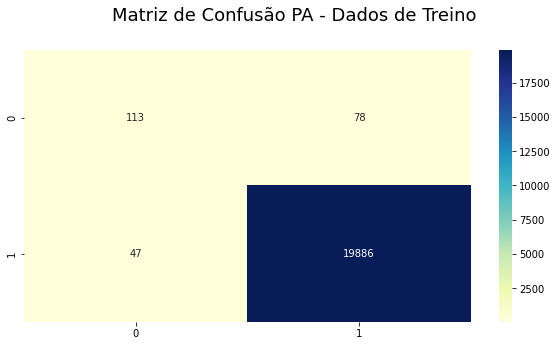



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.72      0.56      0.63        87
           1       1.00      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.86      0.78      0.81      8630
weighted avg       0.99      0.99      0.99      8630





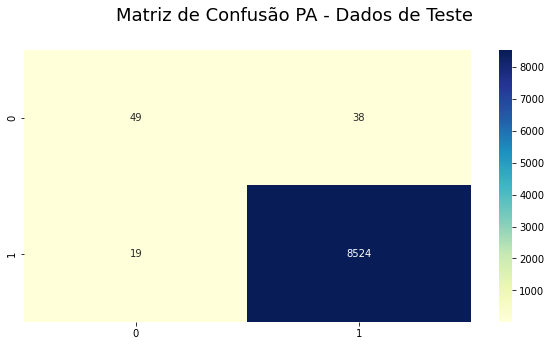

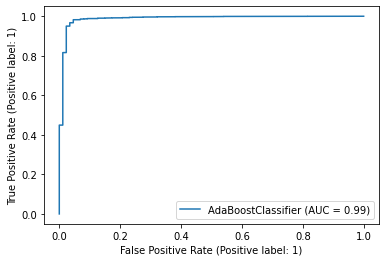

In [40]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model2.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model2.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model2.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model2.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model2.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model2.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model2.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model2.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model2,xteste,yteste)
  plt.show()
  print('\n')

In [41]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model2.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [42]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
33,0.10,v48
73,0.08,v100
34,0.08,v50
127,0.04,v178
189,0.04,v262
...,...,...
76,0.00,v107
77,0.00,v108
78,0.00,v109
79,0.00,v112


In [43]:
n=gc.collect()

##Modelo 3: Gradient Boosting.

In [44]:
model3 = GradientBoostingClassifier(n_estimators=300)

In [45]:
with parallel_backend('dask'):
  model3.fit(xtreino,ytreino)

In [46]:
n=gc.collect()

R² de treino: 0.999900616179686 R² de teste: 0.9947856315179606
RMSE de Treino: 9.938382031405287e-05 RMSE de Teste: 0.005214368482039398


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       191
           1       1.00      1.00      1.00     19933

    accuracy                           1.00     20124
   macro avg       1.00      0.99      1.00     20124
weighted avg       1.00      1.00      1.00     20124





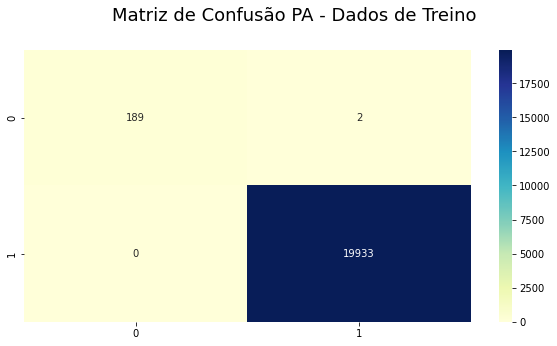



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        87
           1       1.00      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.88      0.85      0.86      8630
weighted avg       0.99      0.99      0.99      8630





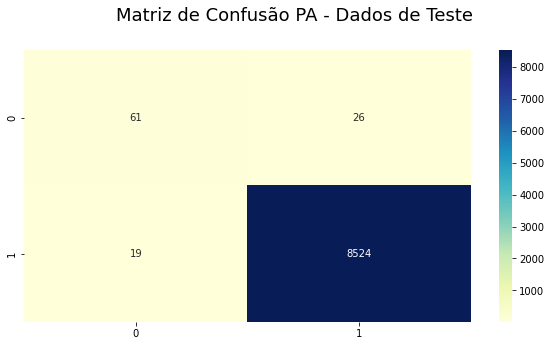

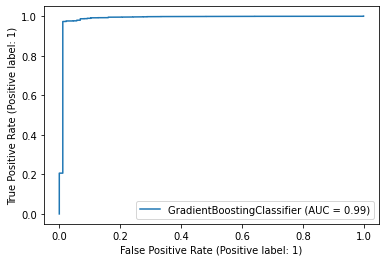

In [47]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model3.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model3.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model3.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model3.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model3.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model3.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model3.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model3.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model3,xteste,yteste)
  plt.show()
  print('\n')

In [48]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model3.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [49]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
51,0.15,v69
165,0.09,v220
117,0.08,v168
84,0.06,v117
149,0.04,v202
...,...,...
126,0.00,v177
125,0.00,v176
124,0.00,v175
123,0.00,v174


In [50]:
n=gc.collect()

##Modelo 4: Bagging.

In [51]:
model4 = BaggingClassifier(n_estimators=1)

In [ ]:
with parallel_backend('dask'):
  model4.fit(xtreino,ytreino)

In [53]:
n=gc.collect()

R² de treino: 0.9969687934804213 R² de teste: 0.993279258400927
RMSE de Treino: 0.0030312065195786126 RMSE de Teste: 0.006720741599073001


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       191
           1       1.00      1.00      1.00     19933

    accuracy                           1.00     20124
   macro avg       0.91      0.93      0.92     20124
weighted avg       1.00      1.00      1.00     20124





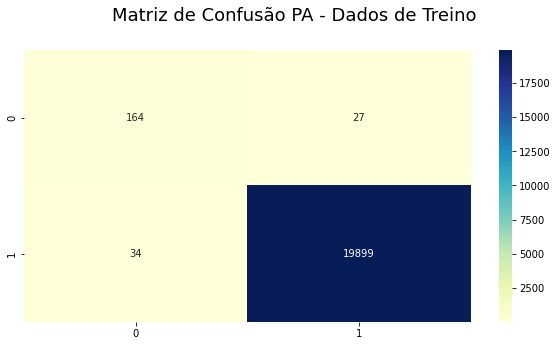



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        87
           1       1.00      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.82      0.86      0.84      8630
weighted avg       0.99      0.99      0.99      8630





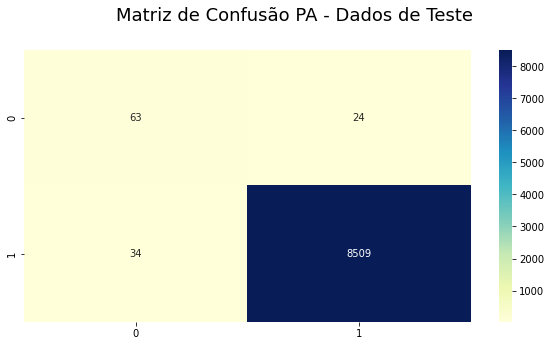

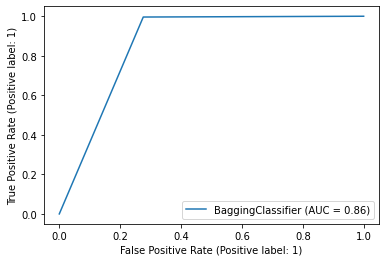

In [54]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model4.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model4.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model4.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model4.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model4.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model4.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model4.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model4.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model4,xteste,yteste)
  plt.show()
  print('\n')

In [55]:
n=gc.collect()

##Modelo 5: Random Forrest.

In [56]:
model5 = RandomForestClassifier(n_estimators=2)

In [ ]:
with parallel_backend('dask'):
  model5.fit(xtreino,ytreino)

In [58]:
n=gc.collect()

R² de treino: 0.9969687934804213 R² de teste: 0.9906141367323291
RMSE de Treino: 0.0030312065195786126 RMSE de Teste: 0.009385863267670916


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       191
           1       1.00      1.00      1.00     19933

    accuracy                           1.00     20124
   macro avg       0.88      0.99      0.93     20124
weighted avg       1.00      1.00      1.00     20124





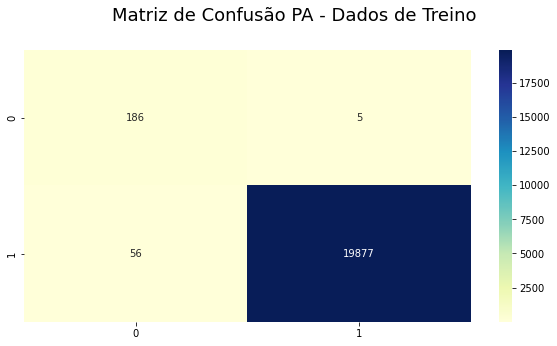



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.52      0.82      0.64        87
           1       1.00      0.99      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.76      0.90      0.82      8630
weighted avg       0.99      0.99      0.99      8630





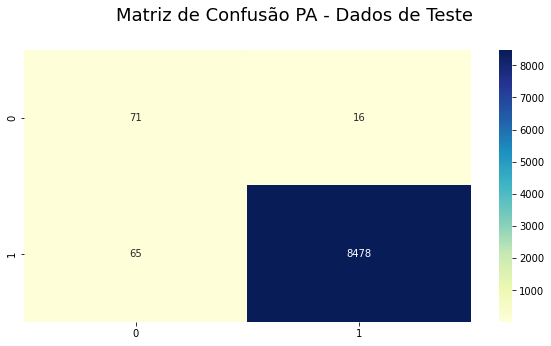

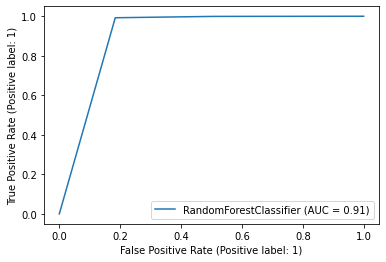

In [59]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model5.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model5.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model5.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model5.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model5.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model5.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model5.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model5.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model5,xteste,yteste)
  plt.show()
  print('\n')

In [60]:
with parallel_backend('dask'):
  importancia01a = pd.DataFrame(model5.feature_importances_ )
t2= t1[['v0','v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v19','v20','v21','v22','v23','v27','v28','v29','v30','v31','v32','v33','v43','v44','v45','v46','v47','v48','v50','v51','v52','v54','v55','v56','v57','v59','v60','v61','v62','v63','v64','v65','v66','v67','v68','v69','v70','v72','v73','v76','v77','v78','v79','v80','v83','v85','v87','v88','v89','v90','v91','v92','v93','v94','v96','v97','v98','v100','v101','v106','v107','v108','v109','v112','v113','v114','v115','v116','v117','v118','v121','v122','v123','v124','v125','v126','v127','v128','v137','v138','v139','v141','v143','v145','v147','v149','v151','v153','v155','v156','v157','v158','v159','v160','v161','v162','v163','v164','v165','v166','v167','v168','v169','v170','v171','v172','v173','v174','v175','v176','v177','v178','v179','v180','v181','v182','v183','v184','v185','v186','v187','v188','v189','v192','v193','v194','v195','v196','v197','v198','v199','v200','v201','v202','v203','v204','v205','v206','v207','v208','v209','v210','v211','v212','v213','v215','v216','v218','v219','v220','v221','v222','v223','v224','v234','v235','v237','v238','v239','v241','v242','v243','v244','v245','v246','v247','v248','v249','v250','v261','v251','v252','v260','v262','v259']]
importancia01a['02'] = pd.DataFrame(t2.columns)

In [61]:
importancia01 = importancia01a.sort_values(by=0,ascending=False)
importancia01.head(200)

,0,02
190,0.12,v259
35,0.11,v51
164,0.09,v219
25,0.04,v31
121,0.03,v172
...,...,...
69,0.00,v94
123,0.00,v174
122,0.00,v173
70,0.00,v96


In [62]:
n=gc.collect()

##Modelo 6: Suport Vector Machine (kernel rbf).

In [63]:
model6 = SVC(C=30000)

In [ ]:
with parallel_backend('dask'):
  model6.fit(xtreino,ytreino)

In [65]:
n=gc.collect()

R² de treino: 0.9920989862850328 R² de teste: 0.9909617612977983
RMSE de Treino: 0.007901013714967204 RMSE de Teste: 0.009038238702201622


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       1.00      0.17      0.29       191
           1       0.99      1.00      1.00     19933

    accuracy                           0.99     20124
   macro avg       1.00      0.58      0.64     20124
weighted avg       0.99      0.99      0.99     20124





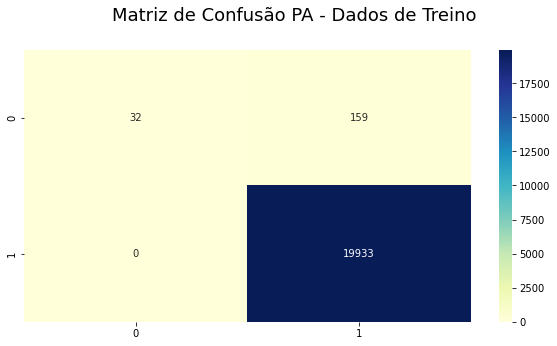



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.85      0.13      0.22        87
           1       0.99      1.00      1.00      8543

    accuracy                           0.99      8630
   macro avg       0.92      0.56      0.61      8630
weighted avg       0.99      0.99      0.99      8630





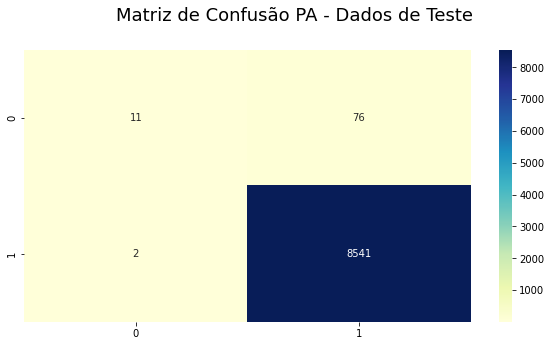

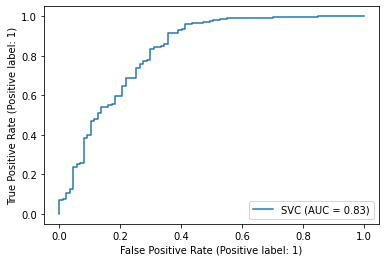

In [66]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model6.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model6.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model6.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model6.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model6.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model6.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model6.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model6.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model6,xteste,yteste)
  plt.show()
  print('\n')

In [67]:
n=gc.collect()

##Modelo 7: KNN.

In [68]:
model7 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
with parallel_backend('dask'):
  model7.fit(xtreino,ytreino)

In [70]:
n=gc.collect()

R² de treino: 0.9919002186444047 R² de teste: 0.990034762456547
RMSE de Treino: 0.008099781355595309 RMSE de Teste: 0.00996523754345307


Reporte dos Dados de Treino - PA
              precision    recall  f1-score   support

           0       0.87      0.17      0.29       191
           1       0.99      1.00      1.00     19933

    accuracy                           0.99     20124
   macro avg       0.93      0.59      0.64     20124
weighted avg       0.99      0.99      0.99     20124





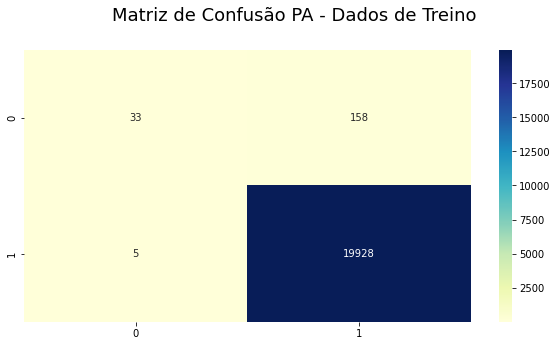



Reporte dos Dados de Teste - PA
              precision    recall  f1-score   support

           0       0.53      0.11      0.19        87
           1       0.99      1.00      0.99      8543

    accuracy                           0.99      8630
   macro avg       0.76      0.56      0.59      8630
weighted avg       0.99      0.99      0.99      8630





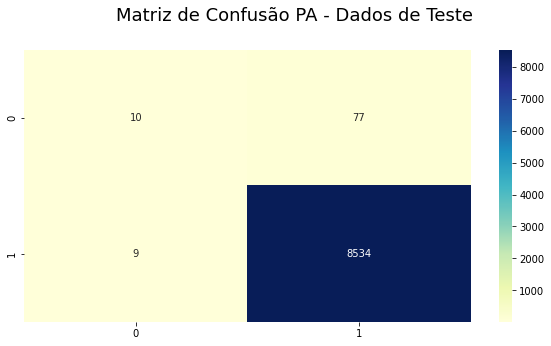

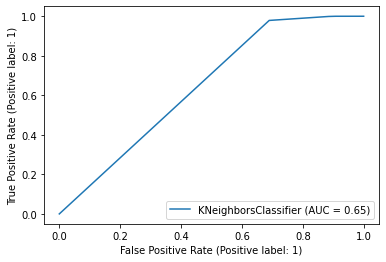

In [71]:
with parallel_backend('dask'):
  print('\033[1m'+'R² de treino:'+'\033[0m',model7.score(xtreino,ytreino),'\033[1m'+'R² de teste:'+'\033[0m',model7.score(xteste,yteste))
  print('\033[1m'+'RMSE de Treino:'+'\033[0m',mean_squared_error(ytreino, model7.predict(xtreino)),'\033[1m'+'RMSE de Teste:'+'\033[0m',mean_squared_error(yteste, model7.predict(xteste)))
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Treino - PA'+'\033[0m')
  print(classification_report(ytreino, model7.predict(xtreino)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_treino = confusion_matrix(ytreino,  model7.predict(xtreino))
  sns.heatmap(pd.DataFrame(cnf_matrix_treino), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Treino',y=1,fontsize=18)
  plt.show()
  print('\n')

  print('\033[1m'+'Reporte dos Dados de Teste - PA'+'\033[0m')
  print(classification_report(yteste, model7.predict(xteste)))
  print('\n')

  plt.figure(figsize=(10, 5))
  cnf_matrix_teste = confusion_matrix(yteste,  model7.predict(xteste))
  sns.heatmap(pd.DataFrame(cnf_matrix_teste), annot=True, cmap="YlGnBu" ,fmt='g')
  plt.suptitle('Matriz de Confusão PA - Dados de Teste',y=1,fontsize=18)
  plt.show()
  print('\n')

  metrics.plot_roc_curve(model7,xteste,yteste)
  plt.show()
  print('\n')

In [72]:
n=gc.collect()

##Consolidação das Curvas ROC

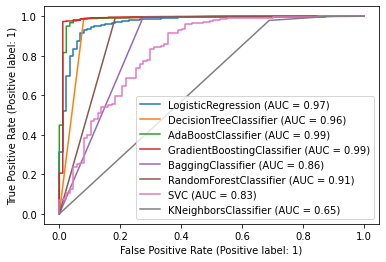

In [73]:
with parallel_backend('dask'):
  classifiers = [model,model1, model2, model3, model4, model5, model6, model7]
  ax = plt.gca()
  for i in classifiers:
      metrics.plot_roc_curve(i, xteste, yteste, ax=ax)